**Plot spectra**

Loaded 50 spectra, 279 wavelengths, classes: ['container' 'insect' 'leaf' 'rust' 'soil']


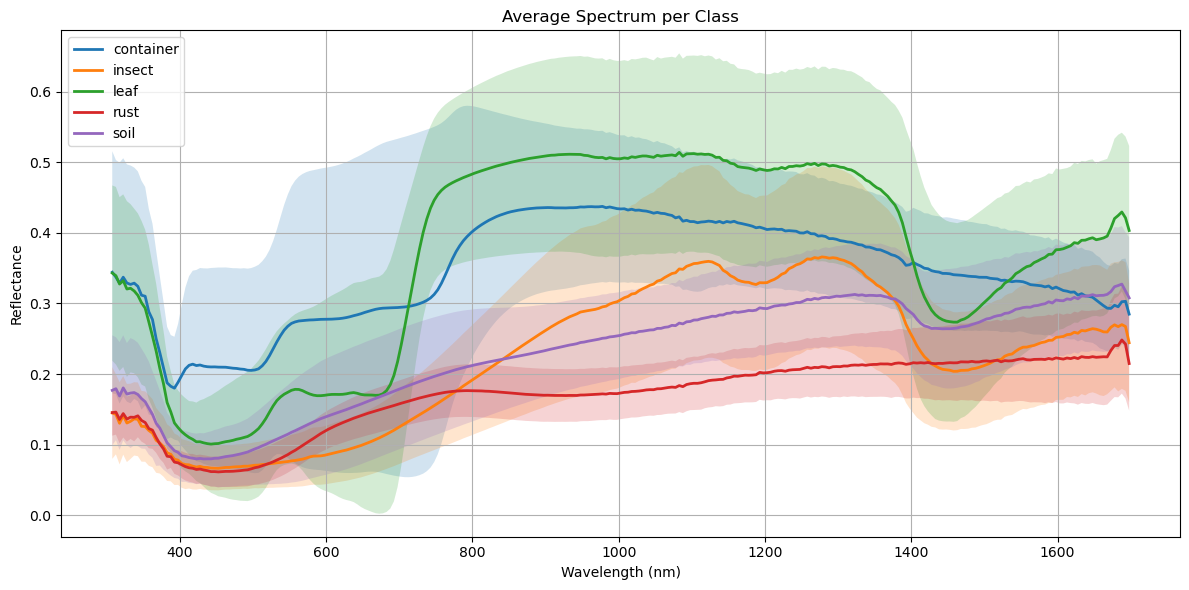

In [94]:
import numpy as np
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt

# Load spectra
folder = r"K:\ALL\coen\exp1\combined"
files = glob.glob(os.path.join(folder, "*_combined.csv"))

X_list = []
y_list = []

for f in files:
    df = pd.read_csv(f)
    refl = df["reflectance"].values
    base = os.path.basename(f).split("_")[0]
    label = re.sub(r"\d+$", "", base)  # remove trailing digits
    X_list.append(refl)
    y_list.append(label)

X = np.vstack(X_list)
y = np.array(y_list)
wavelengths = df["wavelength_nm"].values

print(f"Loaded {X.shape[0]} spectra, {X.shape[1]} wavelengths, classes: {np.unique(y)}")

# Plot average spectra with standard deviation per class
classes_unique = np.unique(y)

plt.figure(figsize=(12,6))

for cls in classes_unique:
    X_cls = X[y == cls]
    mean_spectrum = X_cls.mean(axis=0)
    std_spectrum = X_cls.std(axis=0)

    plt.plot(wavelengths, mean_spectrum, label=cls, linewidth=2)
    plt.fill_between(wavelengths, mean_spectrum - std_spectrum, mean_spectrum + std_spectrum, alpha=0.2)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Average Spectrum per Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Fisher-based ranking**

In [95]:
# Filter out strongly correlated wavelengths
def correlation_filter(X, wavelengths, threshold):
    corr = np.corrcoef(X, rowvar=False)
    keep = np.ones(corr.shape[0], dtype=bool)
    for i in range(corr.shape[0]):
        if keep[i]:
            keep[(corr[i, i+1:] > threshold).nonzero()[0] + (i+1)] = False
    X_reduced = X[:, keep]
    wl_reduced = wavelengths[keep]
    print(f"Correlation filter: kept {X_reduced.shape[1]}/{X.shape[1]} wavelengths")
    return X_reduced, wl_reduced

X, wavelengths = correlation_filter(X, wavelengths, 0.96)

# Filter out wavelengths in the visible range
def filter_visible_range(X, wavelengths, exclude_min, exclude_max):
    wl = np.asarray(wavelengths)
    keep = np.where((wl < exclude_min) | (wl > exclude_max))[0]

    X_reduced = X[:, keep]
    wl_reduced = wavelengths[keep]
    print(f"Excluding visible range: {len(keep)} wavelengths remain")
    return X_reduced, wl_reduced

X, wavelengths = filter_visible_range(X, wavelengths, 300, 700)

# Calculate Fisher scores and sort high to low
def fisher_ranking(X, y, wavelengths):
    classes = np.unique(y)
    n_classes = len(classes)

    overall_mean = X.mean(axis=0)

    results = []

    for i in range(X.shape[1]):
        between = 0.0
        within = 0.0

        for c in classes:
            Xc = X[y == c, i]
            nk = len(Xc)
            mc = Xc.mean()
            vc = Xc.var()

            between += nk * (mc - overall_mean[i])**2
            within += nk * vc

        fisher = between / (within + 1e-12)
        results.append((wavelengths[i], fisher))

    results.sort(key=lambda x: x[1], reverse=True)
    return results

fisher_scores = fisher_ranking(X, y, wavelengths)

print("\nTop 5 wavelengths for multi-class separation (Fisher score):")
for wl, fisher in fisher_scores[:5]:
    print(f"{wl:5.0f} nm    Fisher={fisher:.2f}")


Correlation filter: kept 16/279 wavelengths
Excluding visible range: 9 wavelengths remain

Top 5 wavelengths for multi-class separation (Fisher score):
  853 nm    Fisher=1.64
 1023 nm    Fisher=1.39
  778 nm    Fisher=1.08
 1283 nm    Fisher=0.92
  733 nm    Fisher=0.54


In [96]:
# Calculate binary Fisher score and sort high to low
def binary_fisher_ranking(X, y, wavelengths, class1, class2):
    X1 = X[y == class1]
    X2 = X[y == class2]

    mu1 = X1.mean(axis=0)
    mu2 = X2.mean(axis=0)

    var1 = X1.var(axis=0)
    var2 = X2.var(axis=0)

    fisher = (mu1 - mu2)**2 / (var1 + var2 + 1e-12)

    results = list(zip(wavelengths, fisher))
    results.sort(key=lambda x: x[1], reverse=True)
    return results

binary_fisher_scores = binary_fisher_ranking(X, y, wavelengths, class1='soil', class2='rust')

print("Top 10 wavelengths for soil-rust separation (binary Fisher score):")
for wl, fisher in binary_fisher_scores[:5]:
    print(f"{wl:5.0f} nm    Fisher={fisher:.2f}")


Top 10 wavelengths for soil-rust separation (binary Fisher score):
 1283 nm    Fisher=1.43
 1023 nm    Fisher=1.36
 1388 nm    Fisher=0.91
 1638 nm    Fisher=0.71
  853 nm    Fisher=0.39
